# Function:Train your own model


In [1]:
import torch
#Color code setting
from scrips.Configs import Config
from Mineral_segmentation.Map_prediction_to_real_class import map_prediction_to_real_class

# 路径及参数设置  Path and parameter Settings
input_dir = r'../data/traindata'#输入文件夹 Input folder


#area_limit是提取的最小实例面积，全部提取数量太多且噪声太多 合适的值为200-300
#area_limit is the minimum extracted instance area, all extracted too many and too much noise the appropriate value is 200-300
model_name = 'resnet18' #预训练的模型名称 model name
area_limit = 150 #面积阈值 Area threshold
transparency_threshold=0.15 #线条阈值 Line threshold
batch_size = 64#批大小  batch size
augmentations = 5 #增强倍数 Enhancement factor
num_epochs = 50 #迭代轮次 Iteration round
Training_ratio = 0.8  #训练集比例  Training ratio
#将不同实例按照类别id进行分类并输出 Different instances are classified by category id and output
output_folder_classified_images_labels = './results/classified_instances_with_labels'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classes = Config.Classes_rocks

palette = Config.Palette_rocks

print(classes)
print(len(classes))

['background', 'Hornblende', 'Pyroxene', 'Olivine', 'Anhydrite', 'Quartz', 'Dolomite', 'Plagioclase', 'Muscovite', 'Calcite', 'Aphanocrystalline', 'Cordierite', 'um']
13


In [2]:
from Mineral_segmentation.Load_data import load_images_masks_labels

print("Load labeled data...")
# 用于累积所有批次的数据
images, masks, labels = [], [], []
image_names, mask_names, label_names = [], [], []

# 遍历生成器的每个批次
for images_batch, masks_batch, labels_batch, image_names_batch, mask_names_batch, label_names_batch in load_images_masks_labels(input_dir, batch_size=batch_size):

    # 累积每个批次的数据
    images.extend(images_batch)
    masks.extend(masks_batch)
    labels.extend(labels_batch)
    
    image_names.extend(image_names_batch)
    mask_names.extend(mask_names_batch)
    label_names.extend(label_names_batch)

# 此时，all_images, all_masks, all_labels中保存了所有批次的数据
print(f"Total images loaded: {len(images)}")
print(f"Total masks loaded: {len(masks)}")
print(f"Total labels loaded: {len(labels)}")
print(device)


Load labeled data...


load data: 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]

Total images loaded: 1
Total masks loaded: 1
Total labels loaded: 1
cuda


In [3]:
from Mineral_segmentation.Extract_instances import extract_instances_for_labels

print("Particle extraction...")
# 实例提取（颗粒提取）: 利用sam分割结果提取岩石薄片矿物颗粒
instances_with_label = extract_instances_for_labels(images, masks,labels,area_limit,image_names=image_names,transparency_threshold=transparency_threshold)
print(f"image name {instances_with_label.instances[0].original_image_name}")


Particle extraction...


Extracting instances: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it]

A total of  232 instances are extracted, covering the total image area of  98.58%.
image name 1-8-1-2.jpg


In [4]:
#若输出文件存在，则删除输出文件,防止数据重复,然后构建图像分类训练集和测试集
# If the output file exists, delete it to prevent data duplication，then construct the image classification training set and test set

import os, shutil
path1 = output_folder_classified_images_labels
shutil.rmtree(path1) if os.path.isdir(path1) else os.remove(path1) if os.path.exists(path1) else None
path2 = os.path.dirname(output_folder_classified_images_labels)+'/Test_' + os.path.basename(output_folder_classified_images_labels)
shutil.rmtree(path2) if os.path.isdir(path2) else os.remove(path2) if os.path.exists(path2) else None

# 构造类别id与分类id的对应关系，输入文件夹会根据类别名称排序，因此模型训练与预测的id并不是我们构造的类别id，而是根据字母排序的；若原始classes的顺序是按照字母排序的，则这步无必要，否则下面这步很重要 
# The corresponding relationship between category id and category id is constructed. The input folders will be sorted according to the category name, so the id of model training and prediction is not the category id constructed by us, but is sorted alphabetically. This step is not necessary if the order of the original classes is alphabetical,  otherwise the following step is important

In [5]:
from Mineral_segmentation.Classified_instalces_with_labels import classify_images
import json

#带标签数据的实例提取完成之后执行分类操作，将不同的实例分类至不同id的文件夹，方便执行后续模型训练
#文件名称为类别名称，排序后的、标签数据包含的classname 以及 id字典

sorted_classname,sorted_classname_mapping = classify_images(output_folder_classified_images_labels,classes,skip_id_0=True)

print(output_folder_classified_images_labels)
print(len(sorted_classname))
print(sorted_classname)
print(len(sorted_classname_mapping))
print(sorted_classname_mapping)


import json
data_converted = {key: int(value) for key, value in sorted_classname_mapping.items()}

# 将字典写入 JSON 文件
with open('sorted_classname_mapping.json', 'w') as json_file:
    json.dump(data_converted, json_file, indent=4)  # indent=4 用于格式化输出，使 JSON 文件更易读

print("字典已写入 sorted_classname_mapping.json 文件。")




Classify with class name: 100%|██████████| 232/232 [00:04<00:00, 48.67it/s] 

./results/classified_instances_with_labels
3
['Muscovite', 'Quartz', 'um']
3
{'Muscovite': 8, 'Quartz': 5, 'um': 12}
字典已写入 sorted_classname_mapping.json 文件。


# 划分训练集和测试集合  训练集保持在原始位置，测试集输出到新文件夹
# Split training set and test set The training set remains in its original location, and the test set is output to a new folder


In [6]:
from Dataset.split_train_test_data import split_test_img_for_one_floder
# 构造“一级训练集”和“一级测试集”  
# This is to construct the "training set-particle"
test_data_basename = split_test_img_for_one_floder(output_folder_classified_images_labels,Training_ratio)


C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
Test set partition: 100%|██████████| 3/3 [00:00<00:00, 52.77it/s]


In [7]:
from Dataset.data_enhance_for_one import process_img_augment_for_one_floder

#对分类后的“一级训练集”进行数据增强
# Perform data enhancement on the "training set-particle" after classification
process_img_augment_for_one_floder(output_folder_classified_images_labels,augmentations,device=device)


Data enhancement: 100%|██████████| 3/3 [00:02<00:00,  1.28it/s]


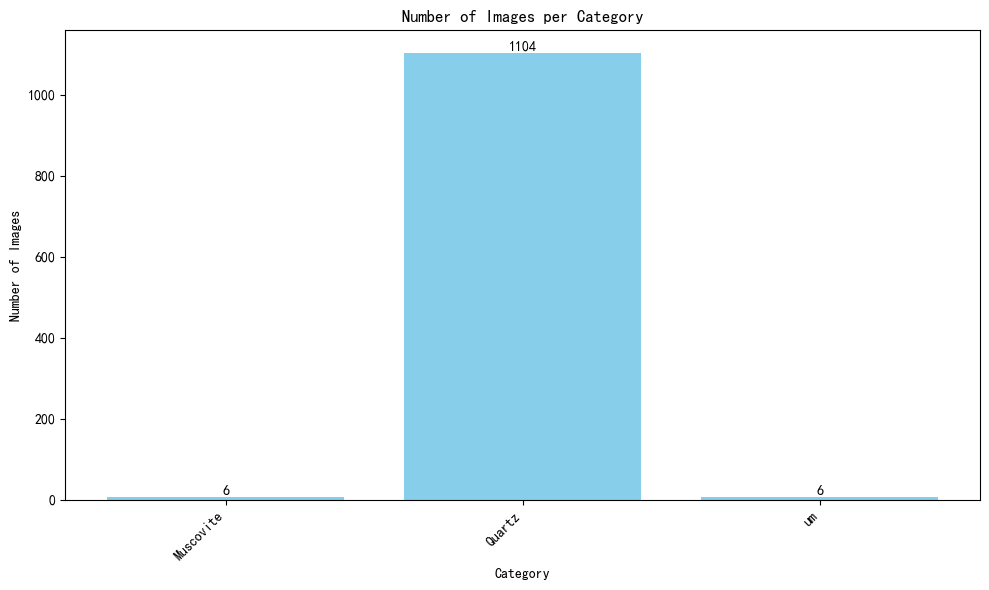

In [8]:
from Dataset.plot_img_count import plot_image_counts
# 统计不同类别的颗粒数量
# The number of particles of different categories was counted
plot_image_counts(output_folder_classified_images_labels)

# 开始模型训练 Start training the models

In [9]:
# ImageClassifier parameter Settings
#model_name
#resnet18、resnet50、resnet152、mobilenet_v2、densenet121、alexnet、vgg16
#lossname
#'CrossEntropyLoss'  'WeightedCrossEntropyLoss'  'FocalLoss'

C:\ProgramData\anaconda3\envs\SAMRocks\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\envs\SAMRocks\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/50: 100%|██████████| 14/14 [00:06<00:00,  2.28it/s, loss=0.00865, accuracy=0.9]   


Save at 0 - [1/50], Loss: 0.1788, Accuracy: 0.9002


Epoch 2/50: 100%|██████████| 14/14 [00:05<00:00,  2.51it/s, loss=0.0031, accuracy=0.994]  


Save at 1 - [2/50], Loss: 0.0215, Accuracy: 0.9944


Epoch 3/50: 100%|██████████| 14/14 [00:05<00:00,  2.68it/s, loss=3.59e-5, accuracy=0.997] 


Save at 2 - [3/50], Loss: 0.0043, Accuracy: 0.9966


Epoch 6/50: 100%|██████████| 14/14 [00:04<00:00,  2.92it/s, loss=0.000845, accuracy=0.998]


Save at 5 - [6/50], Loss: 0.0011, Accuracy: 0.9978


Epoch 7/50: 100%|██████████| 14/14 [00:04<00:00,  2.97it/s, loss=5.94e-5, accuracy=0.998] 


Save at 6 - [7/50], Loss: 0.0008, Accuracy: 0.9978


Epoch 9/50: 100%|██████████| 14/14 [00:04<00:00,  2.94it/s, loss=0.00025, accuracy=0.999] 


Save at 8 - [9/50], Loss: 0.0006, Accuracy: 0.9989


Epoch 10/50: 100%|██████████| 14/14 [00:04<00:00,  2.98it/s, loss=8.15e-5, accuracy=1]


Save at 9 - [10/50], Loss: 0.0001, Accuracy: 1.0000


Epoch 11/50: 100%|██████████| 14/14 [00:04<00:00,  2.89it/s, loss=2.76e-6, accuracy=1]


Save at 10 - [11/50], Loss: 0.0001, Accuracy: 1.0000


Epoch 12/50: 100%|██████████| 14/14 [00:04<00:00,  2.95it/s, loss=9.99e-6, accuracy=1]


Save at 11 - [12/50], Loss: 0.0000, Accuracy: 1.0000


Epoch 14/50: 100%|██████████| 14/14 [00:04<00:00,  2.95it/s, loss=5.65e-6, accuracy=1]


Save at 13 - [14/50], Loss: 0.0000, Accuracy: 1.0000


Epoch 15/50: 100%|██████████| 14/14 [00:04<00:00,  2.95it/s, loss=6.88e-6, accuracy=1]


Save at 14 - [15/50], Loss: 0.0000, Accuracy: 1.0000


Epoch 21/50: 100%|██████████| 14/14 [00:04<00:00,  3.00it/s, loss=1.14e-6, accuracy=1]


Save at 20 - [21/50], Loss: 0.0000, Accuracy: 1.0000


Epoch 22/50: 100%|██████████| 14/14 [00:04<00:00,  3.02it/s, loss=1.29e-5, accuracy=1]


Save at 21 - [22/50], Loss: 0.0000, Accuracy: 1.0000


Epoch 24/50: 100%|██████████| 14/14 [00:04<00:00,  3.02it/s, loss=3.57e-6, accuracy=1]


Save at 23 - [24/50], Loss: 0.0000, Accuracy: 1.0000


Epoch 25/50: 100%|██████████| 14/14 [00:04<00:00,  2.90it/s, loss=3.39e-7, accuracy=1]


Save at 24 - [25/50], Loss: 0.0000, Accuracy: 1.0000


Epoch 27/50: 100%|██████████| 14/14 [00:04<00:00,  2.94it/s, loss=2.62e-6, accuracy=1]


Save at 26 - [27/50], Loss: 0.0000, Accuracy: 1.0000


Epoch 28/50: 100%|██████████| 14/14 [00:04<00:00,  2.95it/s, loss=1.36e-6, accuracy=1]


Save at 27 - [28/50], Loss: 0.0000, Accuracy: 1.0000


Epoch 30/50: 100%|██████████| 14/14 [00:04<00:00,  2.93it/s, loss=1.73e-6, accuracy=1]


Save at 29 - [30/50], Loss: 0.0000, Accuracy: 1.0000


Epoch 35/50: 100%|██████████| 14/14 [00:04<00:00,  3.01it/s, loss=3.71e-6, accuracy=1]


Save at 34 - [35/50], Loss: 0.0000, Accuracy: 1.0000


Epoch 37/50: 100%|██████████| 14/14 [00:04<00:00,  3.00it/s, loss=7.63e-7, accuracy=1]


Save at 36 - [37/50], Loss: 0.0000, Accuracy: 1.0000


Epoch 38/50: 100%|██████████| 14/14 [00:04<00:00,  3.01it/s, loss=6.09e-7, accuracy=1]


Save at 37 - [38/50], Loss: 0.0000, Accuracy: 1.0000


Epoch 40/50: 100%|██████████| 14/14 [00:04<00:00,  3.00it/s, loss=1.83e-6, accuracy=1]


Save at 39 - [40/50], Loss: 0.0000, Accuracy: 1.0000


Epoch 44/50: 100%|██████████| 14/14 [00:04<00:00,  3.00it/s, loss=3.03e-7, accuracy=1]


Save at 43 - [44/50], Loss: 0.0000, Accuracy: 1.0000


Epoch 47/50: 100%|██████████| 14/14 [00:04<00:00,  3.01it/s, loss=1.5e-7, accuracy=1] 


Save at 46 - [47/50], Loss: 0.0000, Accuracy: 1.0000


Epoch 50/50: 100%|██████████| 14/14 [00:04<00:00,  3.01it/s, loss=5.77e-7, accuracy=1]


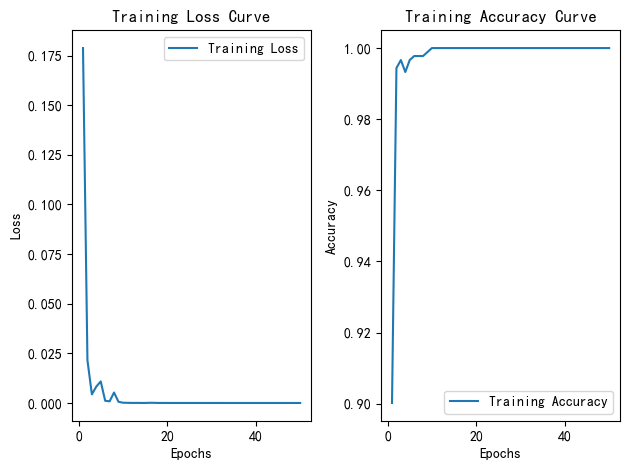

In [10]:
from Mineral_segmentation.Classify_tools import ImageClassifier

classifier= ImageClassifier(data_dir=output_folder_classified_images_labels, model_name=model_name, batch_size=batch_size, num_epochs=num_epochs, learning_rate=0.001,lossname='FocalLoss')  
 # 训练模型
classifier.train_model() 

In [11]:
# 测试并评价模型
report,cm=classifier.evaluate_model()


Evaluating: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s]

Test Accuracy: 1.0000
Balanced Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

   Muscovite       0.00      0.00      0.00         0
      Quartz       1.00      1.00      1.00       224
          um       0.00      0.00      0.00         0

   micro avg       1.00      1.00      1.00       224
   macro avg       0.33      0.33      0.33       224
weighted avg       1.00      1.00      1.00       224


# 使用训练的模型进行测试
# Test using the trained model

In [12]:
from Mineral_segmentation.Classify_tools import ImagePredictor

predictor = ImagePredictor(
        model_path=classifier.model_save_path,
    
        model_name= classifier.model_name
    )
Threshold = 0#概率阈值，小于此概率的会被过滤

C:\ProgramData\anaconda3\envs\SAMRocks\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\envs\SAMRocks\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
D:\XueRenWorkplace\pycharmworkplace\SAMRocks\Mineral_segmentation\Classify_tools.py:495: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, t

In [13]:
from tqdm import tqdm

#test
folder_names = [name for name in os.listdir(test_data_basename) if os.path.isdir(os.path.join(test_data_basename, name))]



pre_result = {}
name_len={}
for name in tqdm(folder_names,desc='test set-particle'):
    path = os.path.join(test_data_basename, name)
    #当前文件夹对应的label id
    floder_label = sorted_classname_mapping.get(name, "Unknown")

    # print(f'{path}-{name}-{floder_label}')
    # 支持的图片扩展名
    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')
    # 获取文件夹中的所有文件，并筛选出图片
    image_files = [f for f in os.listdir(path) if f.lower().endswith(image_extensions)]
    # print(image_files[0])
    right = 0
    for img in image_files:
        img_path = os.path.join(path,img)
         #来到了一个文件夹下面开始预测
        predicted_class,prob = predictor.predict(img_path)
        #更新实例类别
        if prob >= Threshold:

             pre_real_class = map_prediction_to_real_class(sorted_classname_mapping,sorted_classname[predicted_class])
             
             if pre_real_class == sorted_classname_mapping.get(name):
                 right += 1

    name_len[name] =  len(image_files)        
    pre_result[name] = right/len(image_files)


print('Accuracy of test set-particle:')
print(pre_result)
print('Number of  test set-particle:')
print(name_len)


test set-particle: 100%|██████████| 3/3 [00:00<00:00,  8.25it/s]

Accuracy of test set-particle:
{'Muscovite': 0.0, 'Quartz': 1.0, 'um': 1.0}
Number of  test set-particle:
{'Muscovite': 1, 'Quartz': 46, 'um': 1}


# 各种矿物"测试集-颗粒"的识别准确在pre_result中
# The identification of various mineral "test sets - particles" is accurate in pre_result

In [14]:
import pandas as pd

# Write the result to a file

# 将数据合并为 DataFrame
df = pd.DataFrame({
    'Class name': list(pre_result.keys()),
    'Predict result': list(pre_result.values()),
    'Test length': [name_len[name] for name in pre_result.keys()]
})
# # 将数据保存到 Excel 文件

excel_path = predictor.model_dir+r'\test_data_result.csv'
# 或者保存为 CSV 文件
df.to_csv(excel_path, index=False)

print(f"Data written: {excel_path}")


Data written: models_result\resnet18\test_data_result.csv


In [15]:
from collections import Counter

right = 0#记录预测正确的次数
# 初始化一个 Counter 用于记录每个类别的出现次数
class_counter = Counter()
label_counter = Counter()
for index in tqdm(range(len(instances_with_label.instances)),desc="Predict",total = len(instances_with_label.instances)):
    instance = instances_with_label.instances[index]#获取一个实例
    path =  instance.image_path
    predicted_class,prob = predictor.predict(path)
    #更新实例类别
    if prob >= Threshold:

         pre_real_class = map_prediction_to_real_class(sorted_classname_mapping,sorted_classname[predicted_class])
    else:
        pre_real_class = -1
    #更新实例类别id   
    # print(real_class)
    instance.cluster_id = int(pre_real_class)#现在的类别名是数字，之后要换成类别与id的映射
    # 记录类别的出现次数
    class_counter[int(pre_real_class)] += 1
    label_counter[instance._label_id] += 1





Predict: 100%|██████████| 232/232 [00:01<00:00, 162.16it/s]


In [16]:
from Mineral_segmentation.Recolor_and_Remask import remask_instance_masks
from Mineral_segmentation.Reassemble import reassemble_image_masks
from Dataset.fill_zero import process_masks

#类别赋予 更新实例的_mask,保存新的掩码图像

instances_with_label = remask_instance_masks(instances_with_label)

out_mask_path = os.path.join(predictor.model_dir,os.path.basename(predictor.model_dir)+'_remask_images')

reassembled_mask_paths = reassemble_image_masks(instances_with_label, images,out_mask_path)

#填补空值 并重新上色
out_color_path = os.path.join(predictor.model_dir,os.path.basename(predictor.model_dir)+'_recolor_images')

process_masks(out_mask_path, out_color_path, palette,flag_fill=False)


paint : 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]


In [17]:
print(f"Result output to \n {out_mask_path} \n and \n {out_color_path}")

Result output to 
 models_result\resnet18\resnet18_remask_images 
 and 
 models_result\resnet18\resnet18_recolor_images
